In [14]:
#Mineria de datos
#Laboratorio 2
#Anggelie Velasquez 221181
#Anthony Lou 23410
#Isabella Obando 23074
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv("movies_2026.csv", encoding="latin1")
df.head()

,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,releaseYear
0,1627085,0.0,Drama|Crime,NaN,NaN,NaN,NaN,0.0,95,False,...,2026-02-01,0.0,0,2,0,0,8,2.0,5.0,2026.0
1,1626914,0.0,Animation,NaN,NaN,NaN,NaN,0.0,3,False,...,2026-02-01,0.0,0,1,0,0,4,0.0,0.0,2026.0
2,1626898,0.0,Animation,NaN,NaN,NaN,NaN,0.0,2,False,...,2026-02-01,0.0,0,1,0,0,3,0.0,0.0,2026.0
3,1626808,0.0,Thriller|Mystery|Documentary,NaN,NaN,NaN,NaN,0.0,5,False,...,2026-02-01,0.0,0,3,0,0,7,0.0,0.0,2026.0
4,1626678,0.0,Animation,NaN,NaN,NaN,NaN,0.0,12,False,...,2026-02-01,0.0,0,1,0,0,3,0.0,0.0,2026.0


In [16]:
df.columns


Index(['id', 'budget', 'genres', 'homePage', 'productionCompany',
       'productionCompanyCountry', 'productionCountry', 'revenue', 'runtime',
       'video', 'director', 'actors', 'actorsPopularity', 'actorsCharacter',
       'originalTitle', 'title', 'originalLanguage', 'popularity',
       'releaseDate', 'voteAvg', 'voteCount', 'genresAmount',
       'productionCoAmount', 'productionCountriesAmount', 'actorsAmount',
       'castWomenAmount', 'castMenAmount', 'releaseYear'],
      dtype='str')

In [17]:
df = pd.read_csv("movies_2026.csv", encoding="latin1")

df_cluster = df.drop(columns=[
    'id', 'genres', 'homePage', 'productionCompany',
    'productionCompanyCountry', 'productionCountry',
    'director', 'actors', 'actorsCharacter',
    'originalTitle', 'title', 'originalLanguage',
    'releaseDate', 'video',
    'budget', 'revenue',
    'actorsAmount', 'castWomenAmount', 'castMenAmount'
], errors='ignore')

df_cluster = df_cluster.select_dtypes(include=['int64','float64'])

In [18]:
df_cluster.isnull().sum()

runtime                      0
popularity                   0
voteAvg                      0
voteCount                    0
genresAmount                 0
productionCoAmount           0
productionCountriesAmount    0
releaseYear                  2
dtype: int64

In [19]:
df_cluster = df_cluster.select_dtypes(include=['int64','float64'])

In [20]:
df_cluster = df_cluster.fillna(df_cluster.median())

In [21]:
df_cluster.isnull().sum()

runtime                      0
popularity                   0
voteAvg                      0
voteCount                    0
genresAmount                 0
productionCoAmount           0
productionCountriesAmount    0
releaseYear                  0
dtype: int64

In [22]:
(df_cluster['revenue'] == 0).sum()

KeyError: 'revenue'

In [ ]:
(df_cluster['budget'] == 0).sum()

13281

In [ ]:
df_cluster = df_cluster.drop(columns=['budget','revenue'])
df_cluster.head()

,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,releaseYear
0,95,0.0357,0.0,0,2,0,0,8,2.0,5.0,2026.0
1,3,0.0357,0.0,0,1,0,0,4,0.0,0.0,2026.0
2,2,0.0214,0.0,0,1,0,0,3,0.0,0.0,2026.0
3,5,0.0429,0.0,0,3,0,0,7,0.0,0.0,2026.0
4,12,0.0379,0.0,0,1,0,0,3,0.0,0.0,2026.0


In [ ]:
df_cluster.dtypes

runtime                        int64
popularity                   float64
voteAvg                      float64
voteCount                      int64
genresAmount                   int64
productionCoAmount             int64
productionCountriesAmount      int64
actorsAmount                   int64
castWomenAmount              float64
castMenAmount                float64
releaseYear                  float64
dtype: object

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [ ]:
df_cluster.describe()

,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,releaseYear
count,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000
mean,66.093799,26.248842,3.837069,675.927325,1.949253,1.972539,1.230247,1082.049640,3509.965901,8157.367248,2016.827642
std,50.089055,156.067177,3.397705,1938.194656,1.256225,2.312075,2.244688,26402.818732,47724.433405,70970.890375,12.837427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1902.000000
25%,10.000000,0.054600,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,2013.000000
50%,86.000000,8.502000,5.400000,6.000000,2.000000,1.000000,1.000000,9.000000,2.000000,3.000000,2021.000000
75%,103.000000,22.239000,6.800000,423.000000,3.000000,3.000000,1.000000,21.000000,6.000000,11.000000,2025.000000
max,750.000000,11474.647000,10.000000,30788.000000,16.000000,89.000000,155.000000,919590.000000,922162.000000,922017.000000,2026.000000


In [ ]:
df_cluster = df_cluster.drop(columns=[
    'actorsAmount',
    'castWomenAmount',
    'castMenAmount'
])

Se eliminaron las columnas de budget y revenue ya que tenian muchos datos en 0, no se van a tomar en cuenta en el clustering 

In [ ]:
df_cluster.describe()

,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,releaseYear
count,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000,19883.000000
mean,66.093799,26.248842,3.837069,675.927325,1.949253,1.972539,1.230247,2016.827642
std,50.089055,156.067177,3.397705,1938.194656,1.256225,2.312075,2.244688,12.837427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1902.000000
25%,10.000000,0.054600,0.000000,0.000000,1.000000,0.000000,1.000000,2013.000000
50%,86.000000,8.502000,5.400000,6.000000,2.000000,1.000000,1.000000,2021.000000
75%,103.000000,22.239000,6.800000,423.000000,3.000000,3.000000,1.000000,2025.000000
max,750.000000,11474.647000,10.000000,30788.000000,16.000000,89.000000,155.000000,2026.000000


In [ ]:
import numpy as np

df_cluster['popularity'] = np.log1p(df_cluster['popularity'])
df_cluster['voteCount'] = np.log1p(df_cluster['voteCount'])
df_cluster['productionCoAmount'] = np.log1p(df_cluster['productionCoAmount'])
df_cluster['productionCountriesAmount'] = np.log1p(df_cluster['productionCountriesAmount'])

In [ ]:

(df_cluster['runtime'] == 0).sum()

2951

In [ ]:
median_runtime = df_cluster.loc[df_cluster['runtime'] > 0, 'runtime'].median()
median_runtime

90.0

In [ ]:
df_cluster.loc[df_cluster['runtime'] == 0, 'runtime'] = median_runtime

In [ ]:
(df_cluster['runtime'] == 0).sum()


0

Se agregaron valores con la media a valores en 0 de runtime

In [ ]:
zeros_count = (df_cluster == 0).sum()
zeros_count

runtime                         0
popularity                    707
voteAvg                      8326
voteCount                    8302
genresAmount                 1930
productionCoAmount           5241
productionCountriesAmount    3729
releaseYear                     0
dtype: int64

In [ ]:
zeros_percentage = (df_cluster == 0).mean() * 100
zeros_percentage = zeros_percentage.sort_values(ascending=False)
zeros_percentage

voteAvg                      41.874969
voteCount                    41.754262
productionCoAmount           26.359201
productionCountriesAmount    18.754715
runtime                      14.841825
genresAmount                  9.706785
popularity                    3.555801
releaseYear                   0.000000
dtype: float64

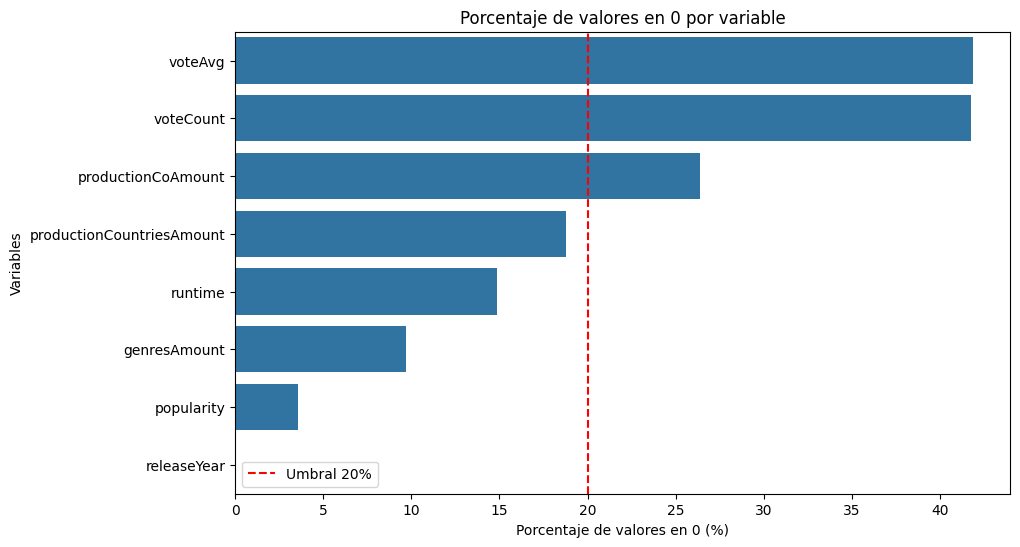

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=zeros_percentage.values, y=zeros_percentage.index)

plt.axvline(x=20, color='red', linestyle='--', label='Umbral 20%')
plt.xlabel("Porcentaje de valores en 0 (%)")
plt.ylabel("Variables")
plt.title("Porcentaje de valores en 0 por variable")
plt.legend()
plt.show()

In [ ]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np

df_cluster['popularity'] = np.log1p(df_cluster['popularity'])
df_cluster['voteCount'] = np.log1p(df_cluster['voteCount'])
df_cluster['productionCoAmount'] = np.log1p(df_cluster['productionCoAmount'])
df_cluster['productionCountriesAmount'] = np.log1p(df_cluster['productionCountriesAmount'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins(X):
    n, d = X.shape
    m = int(0.05 * n)  # usamos 5% para estabilidad
    
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    
    rand_X = np.random.uniform(np.min(X, axis=0),
                               np.max(X, axis=0),
                               (m, d))
    
    u_dist = []
    w_dist = []
    
    for j in range(m):
        u = rand_X[j].reshape(1, -1)
        w = X[np.random.randint(0, n)].reshape(1, -1)
        
        u_dist.append(nbrs.kneighbors(u, 2, return_distance=True)[0][0][1])
        w_dist.append(nbrs.kneighbors(w, 2, return_distance=True)[0][0][1])
    
    H = np.sum(u_dist) / (np.sum(u_dist) + np.sum(w_dist))
    
    return H
hopkins(X_scaled)

ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [29]:
df_cluster.isnull().sum()

runtime                      0
popularity                   0
voteAvg                      0
voteCount                    0
genresAmount                 0
productionCoAmount           0
productionCountriesAmount    0
releaseYear                  0
dtype: int64

In [30]:
df_cluster.isna().any()

runtime                      False
popularity                   False
voteAvg                      False
voteCount                    False
genresAmount                 False
productionCoAmount           False
productionCountriesAmount    False
releaseYear                  False
dtype: bool

In [32]:
df_cluster = df_cluster.replace([np.inf, -np.inf], np.nan)
df_cluster = df_cluster.fillna(df_cluster.median(numeric_only=True))

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [34]:
np.isnan(X_scaled).sum()

0

In [35]:
hopkins(X_scaled)

0.9941922183344126

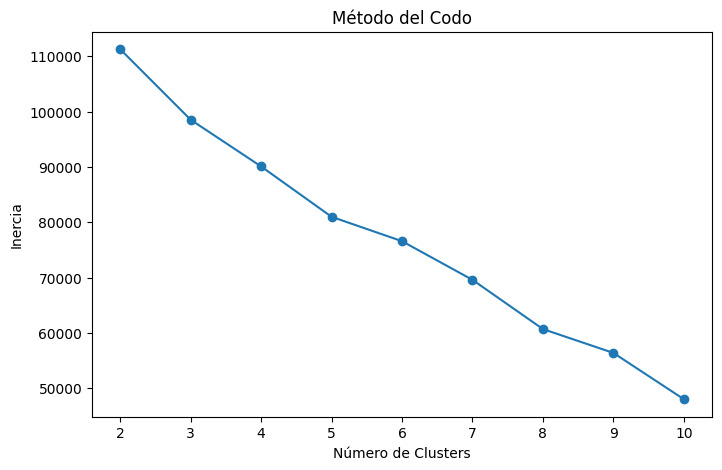

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2,11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo")
plt.show()

In [37]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_cluster['Cluster'] = clusters

In [38]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, clusters)
sil_score

0.38802988395486493

In [39]:
df_cluster.groupby("Cluster").mean()

,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,releaseYear
Cluster,,,,,,,,
0,25.812760,1.080360,0.679472,0.531134,1.191844,0.631221,0.678908,2025.102280
1,120.717514,214.313340,7.206073,8811.121469,2.990113,4.070621,1.514124,2008.545198
2,98.797473,35.841722,6.464976,715.840446,2.563215,3.041878,1.710534,2009.902616
